# Introduction #

First encountering a new dataset can sometimes feel overwhelming. You might be presented with hundreds or thousands of features without even a description to go by. Where do you even begin?

A great first step is to construct a ranking with a **feature utility metric**, a function measuring associations between a feature and the target. Then you can choose a smaller set of the most useful features to develop initially and have more confidence that your time will be well spent.

The metric we'll use is called "mutual information". Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect *any* kind of relationship, while correlation only detects *linear* relationships.

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is:
- easy to use and interpret,
- computationally efficient,
- theoretically well-founded,
- resistant to overfitting, and,
- able to detect any kind of relationship

# Mutual Information and What it Measures #

Mutual information describes relationships in terms of *uncertainty*. The **mutual information** (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

Here's an example from the *Ames Housing* data. The figure shows the relationship between the exterior quality of a house and the price it sold for. Each point represents a house.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/X12ARUK.png" width=400, alt="Four categories of ExterQual: Fair, Typical, Good, Excellent. A scatter plot of SalePrice within each category.">
<figcaption style="textalign: center; font-style: italic"><center>Knowing the exterior quality of a house reduces uncertainty about its sale price.
</center></figcaption>
</figure>

From the figure, we can see that knowing the value of `ExterQual` should make you more certain about the corresponding `SalePrice` -- each category of `ExterQual` tends to concentrate `SalePrice` to within a certain range. The mutual information that `ExterQual` has with `SalePrice` is the average reduction of uncertainty in `SalePrice` taken over the four values of `ExterQual`. Since `Fair` occurs less often than `Typical`, for instance, `Fair` gets less weight in the MI score.

(Technical note: What we're calling uncertainty is measured using a quantity from information theory known as "entropy". The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average." The more questions you have to ask, the more uncertain you must be about the variable. Mutual information is how many questions you expect the feature to answer about the target.)

# Interpreting Mutual Information Scores #

The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

The next figure will give you an idea of how MI values correspond to the kind and degree of association a feature has with the target.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/Dt75E1f.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center><strong>Left:</strong> Mutual information increases as the dependence between feature and target becomes tighter. <strong>Right:</strong> Mutual information can capture any kind of association (not just linear, like correlation.)
</center></figcaption>
</figure>

Here are some things to remember when applying mutual information:
- MI can help you to understand the *relative potential* of a feature as a predictor of the target, considered by itself.
- It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI *can't detect interactions* between features. It is a **univariate** metric.
- The *actual* usefulness of a feature *depends on the model you use it with*. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

# Example - 1985 Automobiles #

The [*Automobile*](https://www.kaggle.com/toramky/automobile-dataset) dataset consists of 193 cars from the 1985 model year. The goal for this dataset is to predict a car's `price` (the target) from 23 of the car's features, such as `make`, `body_style`, and `horsepower`. In this example, we'll rank the features with mutual information and investigate the results by data visualization.

This hidden cell imports some libraries and loads the dataset.

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")

df = pd.read_csv("../input/fe-course-data/autos.csv")
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


The scikit-learn algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that *must* have a `float` dtype is *not* discrete. Categoricals (`object` or `categorial` dtype) can be treated as discrete by giving them a label encoding. (You can review label encodings in our [Categorical Variables](http://www.kaggle.com/alexisbcook/categorical-variables) lesson.)

In [2]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

Scikit-learn has two mutual information metrics in its `feature_selection` module: one for real-valued targets (`mutual_info_regression`) and one for categorical targets (`mutual_info_classif`). Our target, `price`, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [3]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

curb_weight          1.486440
highway_mpg          0.950989
length               0.607955
bore                 0.489772
stroke               0.380041
drive_wheels         0.332973
compression_ratio    0.134799
fuel_type            0.048139
Name: MI Scores, dtype: float64

And now a bar plot to make comparisions easier:

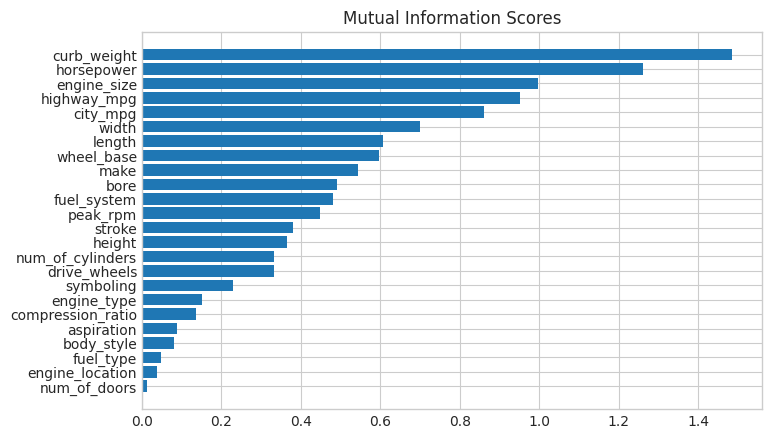

In [4]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Data visualization is a great follow-up to a utility ranking. Let's take a closer look at a couple of these.

As we might expect, the high-scoring `curb_weight` feature exhibits a strong relationship with `price`, the target.


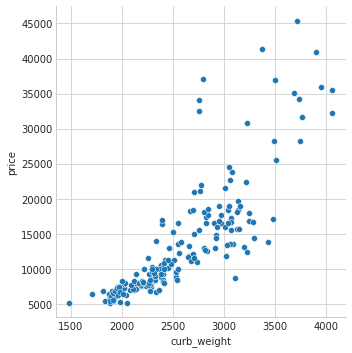

In [5]:
sns.relplot(x="curb_weight", y="price", data=df);

The `fuel_type` feature has a fairly low MI score, but as we can see from the figure, it clearly separates two `price` populations with different trends within the `horsepower` feature. This indicates that `fuel_type` contributes an interaction effect and might not be unimportant after all. Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance here.

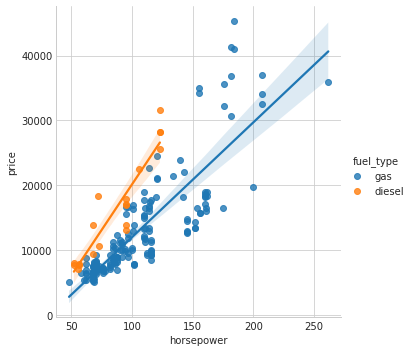

In [6]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);

Data visualization is a great addition to your feature-engineering toolbox. Along with utility metrics like mutual information, visualizations like these can help you discover important relationships in your data. Check out our [Data Visualization](https://www.kaggle.com/learn/data-visualization) course to learn more!

# Your Turn #

[**Rank the features**](https://www.kaggle.com/kernels/fork/14393925) of the *Ames Housing* dataset and choose your first set of features to start developing.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*